In [1]:
import numpy as np
from numpy.linalg import matrix_power
import math
from scipy import optimize
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Main used methods declaration

In [3]:
#Function 1
#define gradient of your function
def Grad_f_x(x):
    return -x/4
def Grad_f_y(y):
    return -2*y/3

def Next_point(lmbda_max, point, S_value):
    #Here you need to define your function  
    def f(x):
        return ((point[0][0]+x*S_value[0][0])**2)/8 + ((point[1][0]+x*S_value[1][0] - 2)**2)/3
    
    result = optimize.minimize_scalar(f)
    
    if result.x < 0:
        min_x = lmbda_max
    elif result.x > lmbda_max:
        min_x = 0
    else:
        min_x = lmbda_max
        
    next_point = np.array([[point[0][0]+min_x*S_value[0][0]],[point[1][0]+min_x*S_value[1][0]]])
    
    return next_point

#Function 2
# #define gradient of your function
# def Grad_f_x(x):
#     return 2*x-2
# def Grad_f_y(y):
#     return 2*y-4

# def Next_point(lmbda_max, point, S_value):
#     x = symbols('x')
#     def f(x):
#         return (point[0][0]+x*S_value[0][0] - 1)**2 + (point[1][0]+x*S_value[1][0] - 2)**2
#     result = optimize.minimize_scalar(f)
    
#     if result.x < 0:
#         min_x = 0
#     elif result.x > lmbda_max:
#         min_x = lmbda_max
#     else:
#         min_x = result.x 
        
#     next_point = np.array([[point[0][0]+min_x*S_value[0][0]],[point[1][0]+min_x*S_value[1][0]]])
    
#     return next_point



def Active_restriction_matrix(A_matrix, B_matrix, point):
    
    matrix = np.array([[]])
    for i in range(0, A_matrix.shape[0]):
        if (round((A_matrix[i][0]*point[0][0]+A_matrix[i][1]*point[1][0]), 3) == round(B_matrix[i][0],3)):
            if matrix.size == 0:
                matrix = np.array([[A_matrix[i][0],A_matrix[i][1]]])
            else:
                matrix = np.vstack((matrix,A_matrix[i]))
    #if matrix.size == 0:
       #matrix = np.append(matrix, [[0, 0]])
        
    return matrix

def P_calculation(Rmatrix):
    
    if Rmatrix.size == 0:
        matrix = np.identity(2)
    elif Rmatrix.dot(np.transpose(Rmatrix)).size == 1:
        matrix_new = np.array([Rmatrix[0][0], Rmatrix[0][1]])
        matrix =  np.identity(2) - (matrix_new[:, np.newaxis])*(matrix_new)/Rmatrix.dot(np.transpose(Rmatrix))  
    else:    
        matrix =  np.identity(2) - (np.transpose(Rmatrix).dot(np.linalg.inv(Rmatrix.dot(np.transpose(Rmatrix))))).dot(Rmatrix) 
        
    return matrix

def S_calculation(P_value, point):
    
    grad_f = (np.array([Grad_f_x(point[0][0]), Grad_f_y(point[1][0])]))[:, np.newaxis]
    s_vector = -P_value.dot(grad_f)
    
    return s_vector

def S_module(S_value):
    return math.sqrt((S_value[0][0])**2 + (S_value[1][0])**2)

def Lambda_calculation(Rmatrix, point):
    
    grad_f = (np.array([Grad_f_x(point[0][0]), Grad_f_y(point[1][0])]))[:, np.newaxis]
    
    if Rmatrix.size == 0:
        lmbda = grad_f
    elif Rmatrix.dot(np.transpose(Rmatrix)).size == 1:
        lmbda = Rmatrix.dot(grad_f)
    else:
        lmbda = ((np.linalg.inv(Rmatrix.dot(np.transpose(Rmatrix)))).dot(Rmatrix)).dot(grad_f)
    
    return lmbda

def Delete_row_rmatrix(Rmatrix, lmbda):
#     x = np.delete(x, (0), axis=0)
    if lmbda.shape[0] > 1:
        if lmbda[0][0]*lmbda[1][0] < 0:
            if lmbda[0][0]<0:
                num = 0
            else:
                num = 1
        else:
            max_num = max(abs(lmbda[0][0]), abs(lmbda[1][0]))
            if (abs(lmbda[0][0]) == max_num):
                num = 0
            else:
                num = 1
    else:
        num = 0
        
    Rmatrix = np.delete(Rmatrix, (num), axis=0)
    
    return Rmatrix


def Lambda_MAX_calculation(A_matrix, B_matrix, S_value, point):
    lmbda_max = 99999
    for i in range(0, A_matrix.shape[0]):
        if (A_matrix[i]).dot(S_value) == 0:
            max_value = 99999
        else:
            max_value = max(0, (B_matrix[i] - (A_matrix[i]).dot(point))/((A_matrix[i]).dot(S_value)))
        
        if (max_value > 0 and max_value < lmbda_max):
            lmbda_max = max_value
    
    
    return lmbda_max


In [4]:
#Main method declaration

In [5]:
#Projected Gradient Decrease method
def PGD_method(A_matrix, B_matrix, epsilon, current_point):
    
    Rmatrix = Active_restriction_matrix(A_matrix, B_matrix, current_point)
    P_value = P_calculation(Rmatrix)
    iteration_num=0
    
    Answer_points = np.array([[current_point[0][0],current_point[1][0]]])
    
    while True:
        
        S_value = S_calculation(P_value, current_point)
        lmbda = Lambda_calculation(Rmatrix, current_point)
        s_module = S_module(S_value)
        
        if lmbda.shape[0] > 1:
        
            if (s_module < epsilon) and ((lmbda[0][0] < 0 and lmbda[1][0] < 0) or (lmbda[0][0] < 0 and lmbda[1][0] > 0) or (lmbda[0][0] > 0 and lmbda[1][0] < 0)) :
                Rmatrix = Delete_row_rmatrix(Rmatrix, lmbda)
                P_value = P_calculation(Rmatrix)
            elif  (s_module < epsilon) and ((lmbda[0][0] >= 0 and lmbda[1][0] >= 0)):
                end_point =  current_point
                break
            elif (s_module >= epsilon):
                lmbda_max = Lambda_MAX_calculation(A_matrix, B_matrix, S_value, current_point)
                current_point = Next_point(lmbda_max[0], current_point, S_value)
                Rmatrix = Active_restriction_matrix(A_matrix, B_matrix, current_point)
                P_value = P_calculation(Rmatrix)
                iteration_num += 1
                Answer_points = np.vstack((Answer_points,np.array([[current_point[0][0],current_point[1][0]]])))
                
        elif lmbda.shape[0] == 1:
            
            if (s_module < epsilon) and (lmbda[0][0] < 0):
                Rmatrix = Delete_row_rmatrix(Rmatrix, lmbda)
                P_value = P_calculation(Rmatrix)
            elif  (s_module < epsilon) and (lmbda[0][0] >= 0):
                end_point =  current_point
                break
            elif (s_module >= epsilon):
                lmbda_max = Lambda_MAX_calculation(A_matrix, B_matrix, S_value, current_point)
                current_point = Next_point(lmbda_max[0], current_point, S_value)
                Rmatrix = Active_restriction_matrix(A_matrix, B_matrix, current_point)
                P_value = P_calculation(Rmatrix)
                iteration_num += 1
                Answer_points = np.vstack((Answer_points,np.array([[current_point[0][0],current_point[1][0]]])))
            
    
    return Answer_points


In [6]:
#Print results

Track your points: 
 [[2.         2.        ]
 [1.         4.        ]
 [1.         4.5       ]
 [1.33333333 4.66666667]]
Minimum of your function:  -7.481481481481483


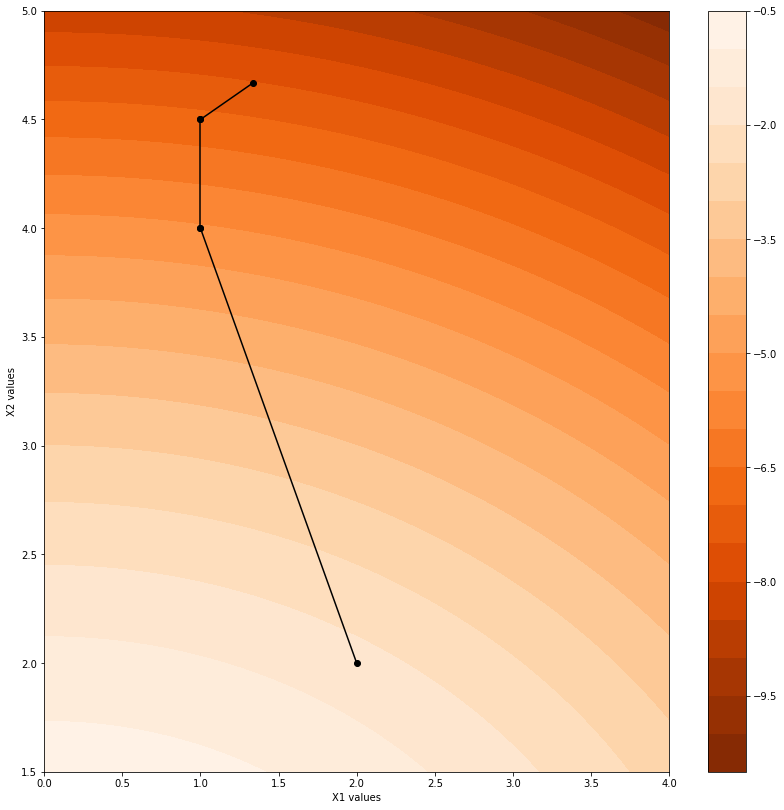

In [7]:
#Function 2
# A_matrix = np.array([[1.0, -2.0], [-1.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
# B_matrix = np.array([[-2.0], [-4.0], [0.0], [0.0]])
# current_point = np.array([[1.2], [1.6]])
# epsilon = 0.01

#Function 1
#define A and B matrix (Ax >= B)
A_matrix = np.array([[-1.0, -1.0], [2.0, 1.0], [-1.0, 1.0], [1/2, -1.0], [1.0, 0.0]])
B_matrix = np.array([[-6.0], [6.0], [-1.0], [-4.0], [1.0]])
#define start point
start_point = np.array([[2.0], [2.0]])
#define epsilon value
epsilon = 0.01

Answer_points = PGD_method(A_matrix, B_matrix, epsilon, start_point)
print("Track your points: \n", Answer_points)

def f(x, y):
    return -(x)**2/8-(y)**2/3

print("Minimum of your function: ", f(Answer_points[Answer_points.shape[0]-1][0],Answer_points[Answer_points.shape[0]-1][1] ))

x = np.linspace(0, 4, 1500)
y = np.linspace(1.5, 5, 1400)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

plt.figure(figsize=(14,14))

plt.contourf(X, Y, Z, 20, cmap='Oranges_r') #'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r'
plt.colorbar();
plt.xlabel('X1 values')
plt.ylabel('X2 values')
for i in range(0,Answer_points.shape[0] -1):
    plt.plot([Answer_points[i][0], Answer_points[i+1][0]], [Answer_points[i][1], Answer_points[i+1][1]], '-ko'  )

Track your points: 
 [[2.         3.        ]
 [2.2        3.8       ]
 [1.33333333 4.66666667]]
Minimum of your function:  -7.481481481481483


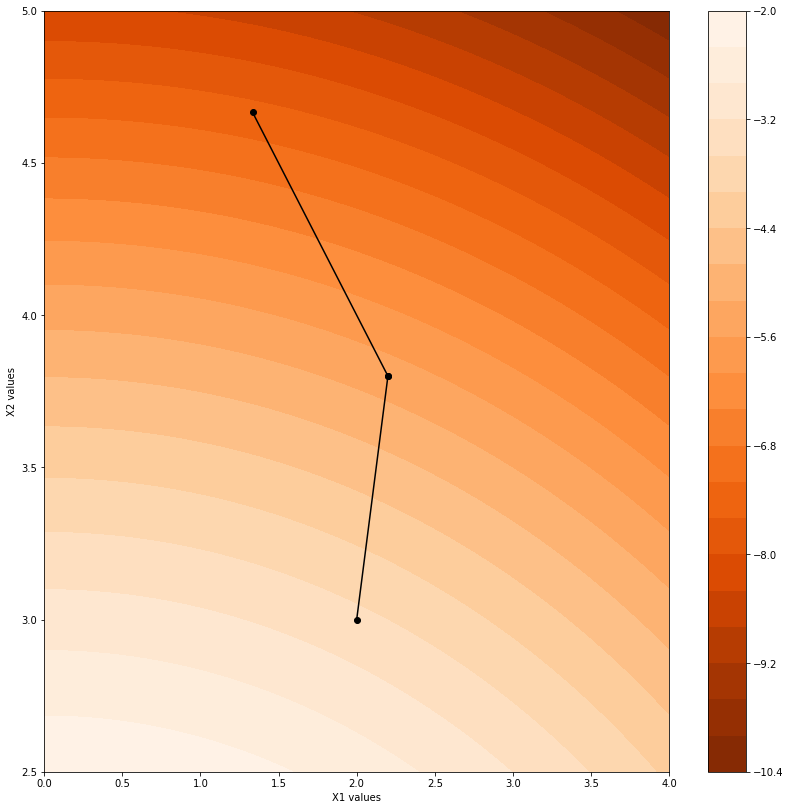

In [8]:
#Function 1
#define A and B matrix (Ax >= B)
A_matrix = np.array([[-1.0, -1.0], [2.0, 1.0], [-1.0, 1.0], [1/2, -1.0], [1.0, 0.0]])
B_matrix = np.array([[-6.0], [6.0], [-1.0], [-4.0], [1.0]])
#define start point
start_point = np.array([[2.0], [3.0]])
#define epsilon value
epsilon = 0.01

Answer_points = PGD_method(A_matrix, B_matrix, epsilon, start_point)
print("Track your points: \n", Answer_points)

def f(x, y):
    return -(x)**2/8-(y)**2/3

print("Minimum of your function: ", f(Answer_points[Answer_points.shape[0]-1][0],Answer_points[Answer_points.shape[0]-1][1] ))

x = np.linspace(0, 4, 1500)
y = np.linspace(2.5, 5, 1400)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

plt.figure(figsize=(14,14))

plt.contourf(X, Y, Z, 20, cmap='Oranges_r') #'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r'
plt.colorbar();
plt.xlabel('X1 values')
plt.ylabel('X2 values')
for i in range(0,Answer_points.shape[0] -1):
    plt.plot([Answer_points[i][0], Answer_points[i+1][0]], [Answer_points[i][1], Answer_points[i+1][1]], '-ko'  )